## [Chapter 5](http://nbviewer.jupyter.org/github/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter5_LossFunctions/Ch5_LossFunctions_PyMC3.ipynb)

Notes and exercises from Cam Davidson's *[Probabilistic Programming and Bayesian Methods for Hackers](https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers)*.

In [19]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from collections import Counter
from IPython.display import display
from scipy import stats
from scipy.misc import comb as nCk
from scipy.optimize import fmin
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pdb

import daft
import theano.tensor as tt
import pymc3 as pm

np.random.seed(865)

'Done'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'Done'

## Loss Functions Overview

- Loss functions quantify the difference between true and estimated parameters: $L(\theta, \hat{\theta}) = f(\theta, \hat{\theta})$
- Often important to focus on the outcomes of the parameter estimation, moreso than the parameters themselves. Example: weather forecasters want to prevent false negatives when predicting rain, so their loss function can be weighted to accomodate this preference.
- In practice, the true parameter, $\theta$, is unknown; we consider it to be a random variable with prior and posterior distributions. To compute an expected loss for an estimated parameter, we can compare it to values drawn from the posterior.

I find the explanations in the early parts of this chapter a little round-about. Basically incorporating a loss-function seems to consist of:

1. Define a model that includes some parameter of interest, $\theta$.
2. Use MCMC to infer a posterior distribution for $\theta$. 
3. Define a loss function $L(\theta, \hat{\theta})$ that quantifies the quality (lower better) of some guess $\hat{\theta}$ based on the posterior distribution inferred above. In contrast to loss functions used in machine learning which take a single value for the true parameter and a single value for the predicted parameter, a loss function in this context takes a posterior distribution for the parameter. The loss function must then quantify the quality of the guess w.r.t. to the posterior distribution for the parameter. The simplest method would be something like returning the likelihood of the guess under the posterior, but often we are interested in other quantities which can be expressed w.r.t the posterior.
4. Use another method, e.g. scipy `fmin`, to find the value of $\hat{\theta}$ which minimizes the loss.

## Example: Optimizing the Showcase on The Price is Right

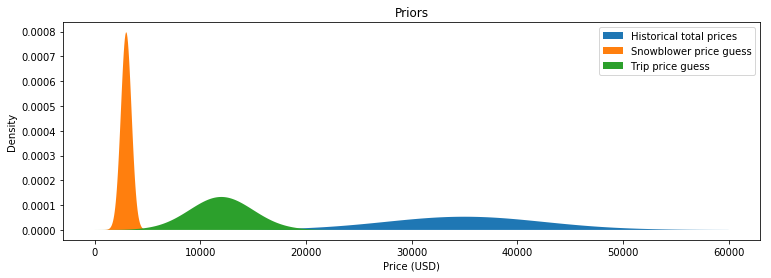

In [22]:
plt.figure(figsize=(12.5, 4))

rv = stats.norm(35000, 7500)
X = np.linspace(0, 60000, 200)
P = rv.pdf(X)
plt.fill_between(X, 0, P, label='Historical total prices')

rv = stats.norm(3000, 500)
X = np.linspace(0, 10000, 200)
P = rv.pdf(X)
plt.fill_between(X, 0, P, label='Snowblower price guess')

rv = stats.norm(12000, 3000)
X = np.linspace(0, 25000, 200)
P = rv.pdf(X)
plt.fill_between(X, 0, P, label='Trip price guess')

plt.title('Priors')
plt.xlabel('Price (USD)')
plt.ylabel('Density')
plt.legend()
plt.show()

The book fails to explain the model in sufficient detail, particularly the role of the `Potential` class in the model, which is used in lieu of real observations and effectively "moves" the posterior to the left. There are some additional explanations here:

1. [pymc3 docs](http://pymc-devs.github.io/pymc/modelbuilding.html#the-potential-class)
2. [stats stack exchange](https://stats.stackexchange.com/questions/251280/what-is-pm-potential-in-pymc3)

He does mention that a later model will incorporate data.

In [23]:
with pm.Model() as pir_model:
    
    price_true = pm.Normal('true_price', mu=35e3, sd=75e2)
    
    prize_1 = pm.Normal('prize_1', mu=3e3, sd=5e2)
    prize_2 = pm.Normal('prize_2', mu=12e3, sd=3e3)
    
    price_pred = prize_1 + prize_2
    
    # TODO: gain intuition for the following two lines that are used 
    # to circumvent including observed values.
    logp = pm.Normal.dist(mu=price_pred, sd=3e3).logp(price_true)
    error = pm.Potential('error', logp)
    
    pir_trace = pm.sample(50000, step=pm.Metropolis())
    pir_burned_trace = pir_trace[10000:]
    
'Done'

Multiprocess sampling (3 chains in 3 jobs)
CompoundStep
>Metropolis: [prize_2]
>Metropolis: [prize_1]
>Metropolis: [true_price]
100%|██████████| 50500/50500 [00:34<00:00, 1448.52it/s]
The number of effective samples is smaller than 10% for some parameters.


'Done'

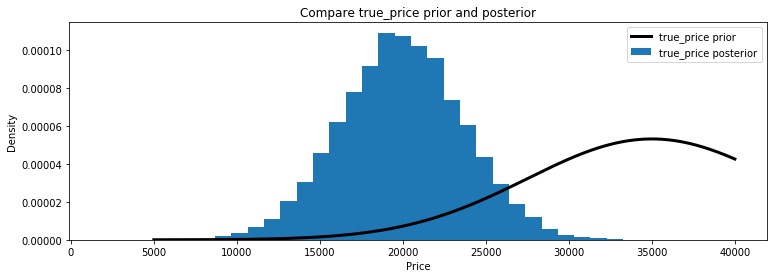

In [26]:
plt.figure(figsize=(12.5, 4))

X = np.linspace(5000, 40000, 200)
rv = stats.norm(35000, 7500)
P = rv.pdf(X)

plt.plot(X, P, lw=3, color='k', label='true_price prior')
plt.hist(pir_burned_trace['true_price'], bins=35, density=True, histtype='stepfilled', label='true_price posterior')

plt.title('Compare true_price prior and posterior')
plt.xlabel('Price')
plt.ylabel('Density')
plt.legend()
plt.show()

Incorporate a loss function that models the game's logic and incentives. Plot the expected loss across various guesses and risk values.

Following the notation from the book, $\theta$ is the posterior sample of true prices, $\hat{\theta}$ is a *single* guess at the price, and the expected loss $E_{\theta}[L(\theta, \hat{\theta}]$ is defined:

$E_{\theta}[L(\theta, \hat{\theta}] \\
= E_{\text{posterior(true_price)}}[L(\text{posterior(true_price)}, \text{guess})] \\
= \frac{1}{|\theta|} \sum_i^{|\theta|} l(\theta_i, \hat{\theta}) $

In words, the expected loss for a single guess is the average loss of that guess against all posterior samples of the true price.

This is slightly complicated below by the fact that we evaluate losses for various "risks".

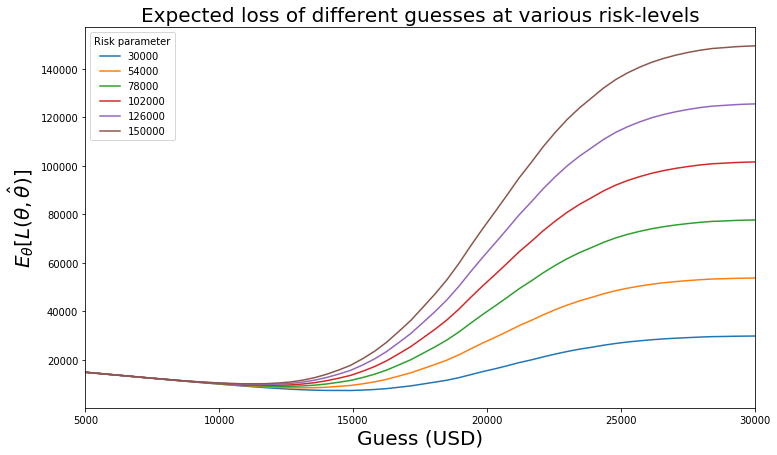

In [24]:
def showdown_loss(guess, true_price_post, risk):
    """Vectorized price is right showdown loss function.
    
    # Arguments:
        guess: a float guess for the showcase.
        true_price_pst: a numpy vector of samples from the posterior of the true price.
        risk: the loss for over-guessing the price.
    
    # Returns:
        loss: a numpy vector of loss values, one for every posterior sample. This can then
            be averaged to get the expected loss.
    
    """
    loss = np.zeros_like(true_price_post)                # Loss value for every posterior sample, start as all zeros.
    ix_over = guess > true_price_post                    # Indices where guess is over and under the true price sample.
    ix_under = ~ ix_over
    ix_bonus = [true_price_post - guess <= 250]          # Indices where guess is within 250 under the true price sample.
    loss[ix_under] = true_price_post[ix_under] - guess   # Populate loss values for under-guesses.
    loss[ix_bonus] = -2 * true_price_post[ix_bonus]      # Populate loss values for bonus-guesses.
    loss[ix_over] = risk                                 # Populate loss values for over-guesses.
    return loss                                          # Return vector of losses, one per posterior sample.
                                                         # This can be averaged to get the expected loss.

guesses = np.linspace(5000, 50000, 101)
risks = np.linspace(30000, 150000, 6)

plt.figure(figsize=(12, 7))

for risk in risks:

    # Get the expected (mean) loss for each guess with this risk value.
    expected_losses = [showdown_loss(guess, pir_burned_trace['true_price'], risk).mean()
                       for guess in guesses]
    
    plt.plot(guesses, expected_losses, label='%d' % risk)
    
plt.title("Expected loss of different guesses at various risk-levels", size=20)
plt.legend(loc="upper left", title="Risk parameter")
plt.xlabel("Guess (USD)", size=20)
plt.ylabel('$E_{θ}[L(θ, \hat{θ})]$', size=20)
plt.xlim(5000, 30000)
plt.show()

Now we can optimize for the *Bayes Action*, which is the guess that minimizes the expected loss:

$ \text{arg} \min_{\hat{\theta}} \;\;E_{\theta}\left[ \; L(\theta, \hat{\theta}) \; \right] $

Finding the Bayes action is equivalent to finding parameters that optimize an arbitrary performance measure. In this case it is the showdown loss function with respect to a posterior sample of true prices and a single risk value.

The plot shows, intuitively, that lower risks allow for higher optimal guesses.

Minimum at risk 30000 = 14806.77
Minimum at risk 54000 = 13297.58
Minimum at risk 78000 = 12519.99
Minimum at risk 102000 = 11843.76
Minimum at risk 126000 = 11700.91
Minimum at risk 150000 = 11048.80


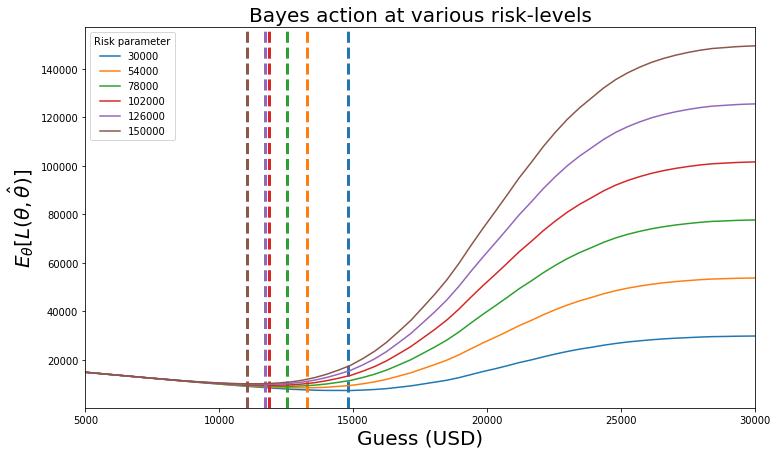

In [25]:
plt.figure(figsize=(12, 7))

for risk in risks:

    # Get the expected (mean) loss for each guess with this risk value.
    expected_losses = [showdown_loss(guess, pir_burned_trace['true_price'], risk).mean()
                       for guess in guesses]

    func = lambda x: showdown_loss(x, pir_burned_trace['true_price'], risk).mean()
    x0 = guesses[np.argmin(expected_losses)]
    min_guess = fmin(func, x0, disp=False)[0]
    
    print('Minimum at risk %d = %.2lf' % (risk, min_guess))
    
    p = plt.plot(guesses, expected_losses, label='%d' % risk)
    plt.axvline(min_guess, ls='--', lw=3, c=p[0].get_color())
    
plt.title("Bayes action at various risk-levels", size=20)
plt.legend(loc="upper left", title="Risk parameter")
plt.xlabel("Guess (USD)", size=20)
plt.ylabel('$E_{θ}[L(θ, \hat{θ})]$', size=20)
plt.xlim(5000, 30000)
plt.show()

## Example: Financial Prediction

First, define and plot a loss function that is particularly loss-averse.

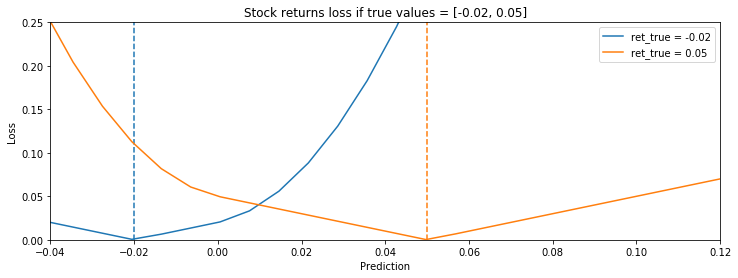

In [3]:
def stock_loss(return_true, return_pred, alpha=100):
    if return_true * return_pred < 0:
        return alpha * (return_pred ** 2) - np.sign(return_true) * return_pred + abs(return_true)
    else:
        return abs(return_true - return_pred)
    
stock_loss = np.vectorize(stock_loss)

rets_true = [-0.02, 0.05]
rets_pred = np.linspace(-0.4, 0.12, 75)

plt.figure(figsize=(12, 4))

for ret_true in rets_true:
    p = plt.plot(rets_pred, stock_loss(ret_true, rets_pred), label='ret_true = %.2lf' % ret_true)
    plt.axvline(ret_true, c=p[0].get_color(), ls='--')
    
plt.title('Stock returns loss if true values = %s' % str(rets_true))
plt.xlim(-0.04, .12)
plt.ylim(0, 0.25)
plt.ylabel('Loss')
plt.xlabel('Prediction')
plt.legend()
plt.show()

Generate a simple feature $X$ that will be used to predict returns, $Y$.

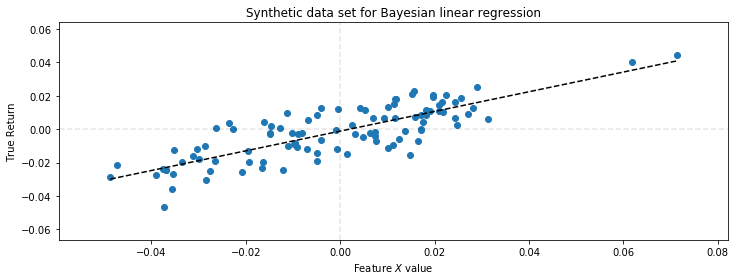

In [14]:
plt.figure(figsize=(12, 4))

# Generate and plot synthetic feature and its returns.
N = 100
X = 0.025 * np.random.randn(N)
Y = 0.5 * X + 0.01*np.random.randn(N)

# Sort by X values for simpler plotting later.
ii = np.argsort(X)
X = X[ii]
Y = Y[ii]

plt.scatter(X, Y)

# Least squares estimation of slope and intercept.
ls_slope = np.cov(X, Y)[0,1] / np.var(X)
ls_incpt = Y.mean() - ls_slope * X.mean()
plt.plot(X, ls_slope * X + ls_incpt, c='k', ls='--', label='Leqst squares estimate')
plt.axvline(0, ls='--', c='k', alpha=0.1)
plt.axhline(0, ls='--', c='k', alpha=0.1)

plt.title('Synthetic data set for Bayesian linear regression')
plt.xlabel('Feature $X$ value')
plt.ylabel('True Return')
plt.show()

Now, infer the parameters $\alpha, \beta$ for model:

$\text{return} = \alpha + \beta x + \epsilon$

In [15]:
with pm.Model() as linreg_model:
    
    alpha = pm.Normal('alpha', mu=0, sd=100)
    beta = pm.Normal('beta', mu=0, sd=100)
    
    mu = pm.Deterministic('mean', alpha + beta * X)
    sd = pm.Uniform('sd', 0, 100)
    
    obs = pm.Normal('obs', mu=mu, sd=sd, observed=Y)
    
    %time linreg_trace = pm.sample(100000, step=pm.Metropolis())
    burned_linreg_trace = linreg_trace[20000:]
    
'Done'

Multiprocess sampling (3 chains in 3 jobs)
CompoundStep
>Metropolis: [sd_interval__]
>Metropolis: [beta]
>Metropolis: [alpha]
100%|██████████| 100500/100500 [01:16<00:00, 1310.35it/s]
The number of effective samples is smaller than 25% for some parameters.


CPU times: user 11.7 s, sys: 1.5 s, total: 13.2 s
Wall time: 1min 29s


'Done'

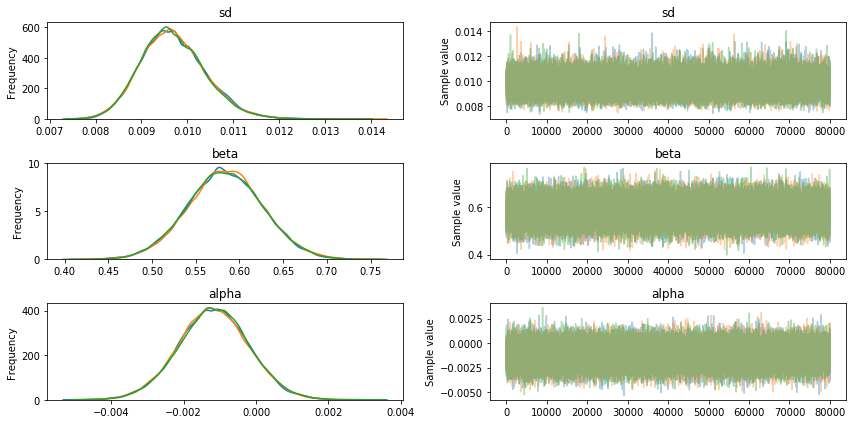

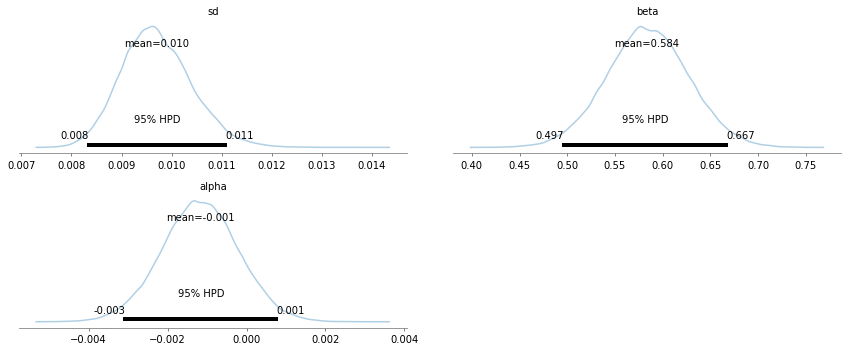

In [16]:
pm.plots.traceplot(trace=burned_linreg_trace, varnames=['sd', 'beta', 'alpha'])
pm.plot_posterior(trace=burned_linreg_trace, varnames=['sd', 'beta', 'alpha'], kde_plot=True)
plt.show()

Compute and plot the expected loss for each return value. As a reminder, the expected loss is the average of the losses evaluated at every $(\alpha, \beta)$ sample in the posterior.

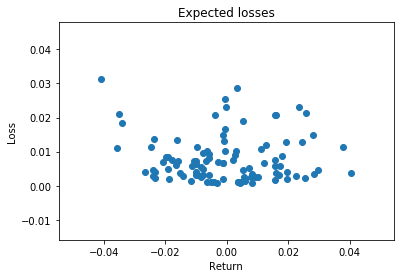

In [13]:
a = burned_linreg_trace['alpha']
b = burned_linreg_trace['beta']
Y_pred = a + np.dot(X[:, np.newaxis], b[np.newaxis, :])

expected_losses = np.zeros(len(X))
for i, (y, YP) in enumerate(zip(Y, Y_pred)):
    expected_losses[i] = stock_loss(y, YP).mean()

plt.title('Expected losses')
plt.scatter(Y, expected_losses)
plt.xlabel('Return')
plt.ylabel('Loss')
plt.show()

0 -0.029437500000000005
1 -0.028000000000000004
2 -0.02650000000000001
3 -0.02493750000000001
4 -0.023375000000000007
5 -0.021812500000000005
6 -0.020187500000000004
7 -0.018500000000000006
8 -0.016812500000000005
9 -0.015125000000000006
10 -0.013375000000000005
11 -0.011687500000000003
12 -0.010000000000000002
13 -0.008375000000000002
14 -0.006875000000000003
15 -0.005500000000000001
16 -0.004250000000000001
17 -0.003125
18 -0.002125
19 -0.00125
20 -0.0005
21 0.0001875
22 0.0009375
23 0.0017500000000000003
24 0.0026875000000000007
25 0.003750000000000001
26 0.004937500000000001
27 0.006250000000000002
28 0.007687500000000003
29 0.009312500000000003
30 0.010937500000000003
31 0.012625000000000004
32 0.014375000000000002
33 0.016125000000000004
34 0.017812500000000005
35 0.019500000000000007
36 0.021125000000000005
37 0.022687500000000006
38 0.0243125
39 0.025812500000000002
40 0.027312500000000003
41 0.028812500000000005
42 0.030312500000000006
43 0.03175000000000001
44 0.0331875000000

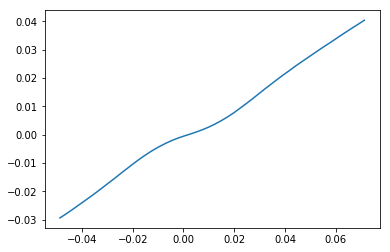

In [21]:
def stock_loss_vectorized(price, pred, coef = 500):
    sol = np.zeros_like(price)
    ix = price*pred < 0 
    sol[ix] = coef*pred**2 - np.sign(price[ix])*pred + abs(price[ix])
    sol[~ix] = abs(price[~ix] - pred)
    return sol

N = len(burned_linreg_trace['sd'])

noise = burned_linreg_trace['sd'] * np.random.randn(N)
fofX = lambda x: burned_linreg_trace['alpha'] + burned_linreg_trace['beta'] * x + noise

X_ = np.linspace(X.min(), X.max(), 50)
Y_pred_opt = np.zeros(len(X_))

# Warning: this is super slow to run!
for i in range(len(X_)):
    YT = fofX(X_[i])
    func = lambda yp: stock_loss(YT, yp).mean()
    Y_pred_opt[i] = fmin(func, x0=0, disp=False)
    
plt.plot(X_, Y_pred_opt)
plt.show()